## BigOAI 

**Your Goal: The objective of this challenge is to predict insurance premiums based on various factors.**

Submissions are evaluated using the Root Mean Squared Logarithmic Error (RMSLE).

Submission File:

- For each id row in the test set, you must predict the continuous target Premium Amount. The file should contain a header and have the following format:

Dataset Description

The dataset for this competition (both train and test) was a combination of Insurance Premium Prediction dataset and Regression with an Insurance Dataset.

Files

train.csv - the training set; **Premium Amount** is the continuous target
test.csv - the test set; your objective is to predict target Premium Amount for each row
sample_submission.csv - a sample submission file in the correct format

since the training set includes the target/label: Premium Amount this is a supervised ML Algo, Regression, batch wise. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install --upgrade lightgbm
import lightgbm
print(lightgbm.__version__)
print(lightgbm.__file__)

/Users/shamsalkhalidy/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


4.6.0
/Users/shamsalkhalidy/anaconda3/lib/python3.11/site-packages/lightgbm/__init__.py


In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
# test.head()

In [36]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,1,32.0,Female,29892.0,Single,0.0,Bachelor's,Employed,6.607965,Suburban,...,0.0,2.0,622.0,7.0,2023-09-23 15:21:39.134960,Poor,Yes,Daily,Condo,817.0
1,2,21.0,Male,77567.0,Divorced,0.0,High School,Self-Employed,NaN,Suburban,...,NaN,0.0,NaN,4.0,2023-10-23 15:21:39.237118,NaN,Yes,Daily,Apartment,1804.0
2,3,61.0,Female,33226.0,Divorced,NaN,Master's,Employed,17.160862,Rural,...,0.0,16.0,398.0,3.0,2021-05-29 15:21:39.155231,Poor,No,Daily,Condo,513.0
3,4,61.0,Male,34013.0,Divorced,4.0,High School,Employed,44.108344,Suburban,...,NaN,5.0,556.0,9.0,2023-06-15 15:21:39.285112,NaN,No,Weekly,Condo,49.0
4,5,NaN,Female,NaN,Married,2.0,Bachelor's,Self-Employed,57.369206,Urban,...,0.0,1.0,750.0,4.0,2020-03-20 15:21:39.118178,NaN,No,Daily,Apartment,1048.0


# EDA

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181615 entries, 0 to 1181614
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1181615 non-null  int64  
 1   Age                   1162958 non-null  float64
 2   Gender                1181615 non-null  object 
 3   Annual Income         1134716 non-null  float64
 4   Marital Status        1162732 non-null  object 
 5   Number of Dependents  1071885 non-null  float64
 6   Education Level       1181615 non-null  object 
 7   Occupation            830455 non-null   object 
 8   Health Score          1113773 non-null  float64
 9   Location              1181615 non-null  object 
 10  Policy Type           1181615 non-null  object 
 11  Previous Claims       826004 non-null   float64
 12  Vehicle Age           1181610 non-null  float64
 13  Credit Score          1048913 non-null  float64
 14  Insurance Duration    1181614 non-

In [38]:
train.isna().sum()    #features with na values sum

id                           0
Age                      18657
Gender                       0
Annual Income            46899
Marital Status           18883
Number of Dependents    109730
Education Level              0
Occupation              351160
Health Score             67842
Location                     0
Policy Type                  0
Previous Claims         355611
Vehicle Age                  5
Credit Score            132702
Insurance Duration           1
Policy Start Date            0
Customer Feedback        76832
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [39]:
# change Policy Start Date type from object to Datetime
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'], errors='coerce')

# categorical columns
cat_col = train.select_dtypes(include=['object']).columns

# numerical columns 
num_col = train.select_dtypes(include=['float64','int']).columns
num_col = [c for c in num_col if c != 'id']   # exclude id column


# train.info()

In [40]:
# -----------numerical values eda
train[num_col].describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1.162958e+06,1.134716e+06,1.071885e+06,1.113773e+06,826004.000000,1.181610e+06,1.048913e+06,1.181614e+06,1.181615e+06
mean,4.111861e+01,3.447367e+04,2.007313e+00,2.618434e+01,1.002357,9.564267e+00,5.893879e+02,5.015615e+00,1.077344e+03
std,1.353959e+01,3.300382e+04,1.416631e+00,1.306298e+01,0.985903,5.775424e+00,1.519299e+02,2.591907e+00,8.747557e+02
min,1.800000e+01,0.000000e+00,0.000000e+00,3.543621e-02,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,0.000000e+00
25%,2.900000e+01,9.062000e+03,1.000000e+00,1.593699e+01,0.000000,5.000000e+00,4.630000e+02,3.000000e+00,4.690000e+02
50%,4.100000e+01,2.499100e+04,2.000000e+00,2.484909e+01,1.000000,1.000000e+01,5.910000e+02,5.000000e+00,8.380000e+02
75%,5.300000e+01,4.630425e+04,3.000000e+00,3.523567e+01,2.000000,1.500000e+01,7.190000e+02,7.000000e+00,1.485000e+03
max,6.400000e+01,1.499970e+05,4.000000e+00,9.387609e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


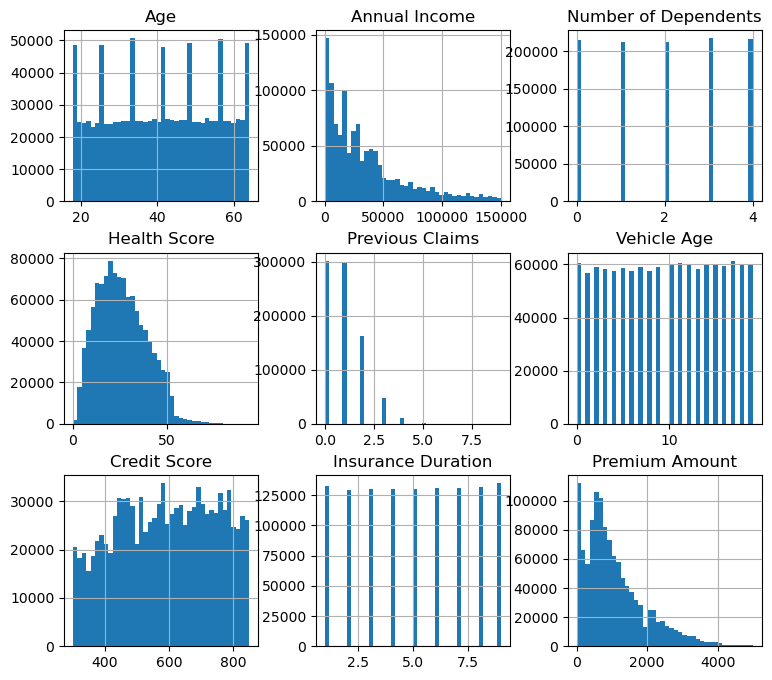

In [41]:
# distribution of each numerical feature; we need to Scale later due to numerical attributes having different scales
train[num_col].hist(figsize=(9,8), bins = 40)
plt.show()

In [42]:
# detect and replace outliers for numerical values (Z-score method)
from scipy import stats

# copy dataset to avoid changing origial dataset
train_clean = train.copy()

# Z score threshold
threshold = 3

for col in num_col:
    # calculate z-scores
    z_score = np.abs(stats.zscore(train[col]))

    # print how many outliers detected;      Counts how many True values exist
    print(f"{col} has {np.sum(z_score > threshold) } outliers detected")

    # capp outliers  ; mean+/-3*std
    mean , std = train_clean[col].mean() , train_clean[col].std()
    lower , upper = mean - threshold * std , mean + threshold * std

    # replace outliers with lower and upper
    train_clean[col] = np.where(train_clean[col] < lower, lower, np.where(train_clean[col] > upper, upper, train_clean[col]))

    print('outliers replaced with cap')

Age has 0 outliers detected
outliers replaced with cap
Annual Income has 0 outliers detected
outliers replaced with cap
Number of Dependents has 0 outliers detected
outliers replaced with cap
Health Score has 0 outliers detected
outliers replaced with cap
Previous Claims has 0 outliers detected
outliers replaced with cap
Vehicle Age has 0 outliers detected
outliers replaced with cap
Credit Score has 0 outliers detected
outliers replaced with cap
Insurance Duration has 0 outliers detected
outliers replaced with cap
Premium Amount has 15986 outliers detected
outliers replaced with cap


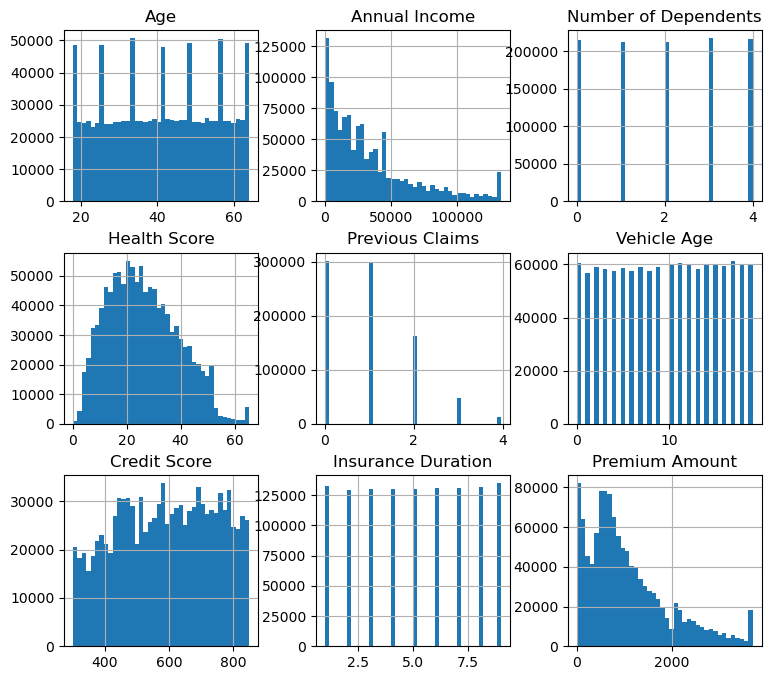

In [43]:
# plot dist after outliers handling; Annual Income and Premium amount are still skewed
train_clean[num_col].hist(figsize=(9,8), bins = 40)
plt.show()

In [44]:
train['Number of Dependents'].value_counts()   # dependants range from 0-4

Number of Dependents
3.0    217099
4.0    215929
0.0    214614
2.0    212353
1.0    211890
Name: count, dtype: int64

In [45]:
# no straight strong correlations between num features and the target Premium Amount
train[num_col].corr()['Premium Amount'].sort_values(ascending=False)

Premium Amount          1.000000
Previous Claims         0.037695
Health Score            0.005802
Vehicle Age             0.000894
Insurance Duration      0.000377
Number of Dependents   -0.000295
Age                    -0.001925
Credit Score           -0.015972
Annual Income          -0.016733
Name: Premium Amount, dtype: float64

In [46]:
# -------------categorical values eda
train[cat_col].describe()

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,1181615,1162732,1181615,830455,1181615,1181615,1104783,1181615,1181615,1181615
unique,2,3,4,3,3,3,3,2,4,3
top,Male,Single,Master's,Employed,Suburban,Premium,Average,Yes,Weekly,House
freq,593048,389074,298418,278814,395486,395881,371516,592736,300547,394435


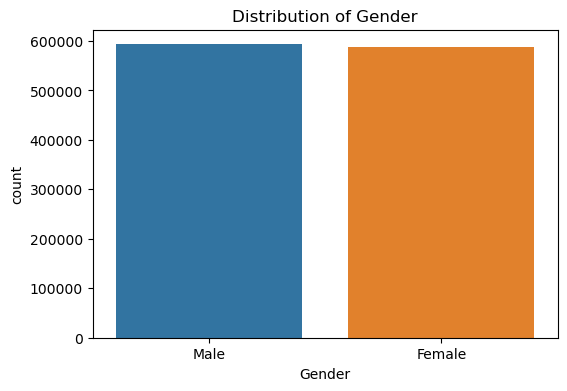

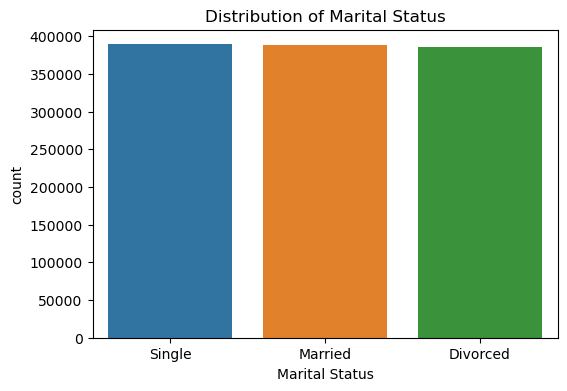

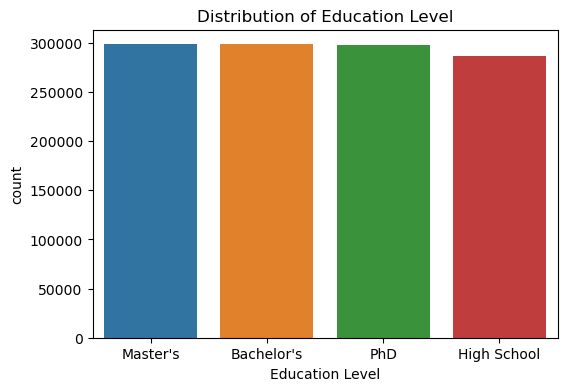

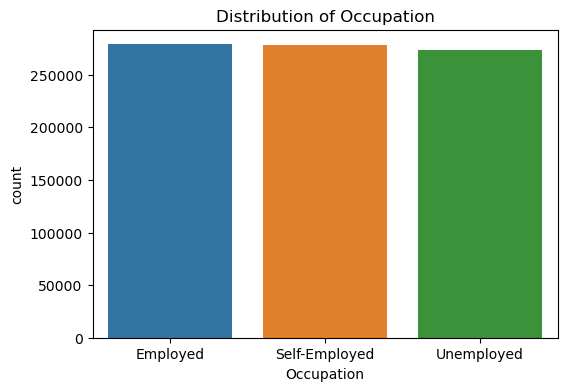

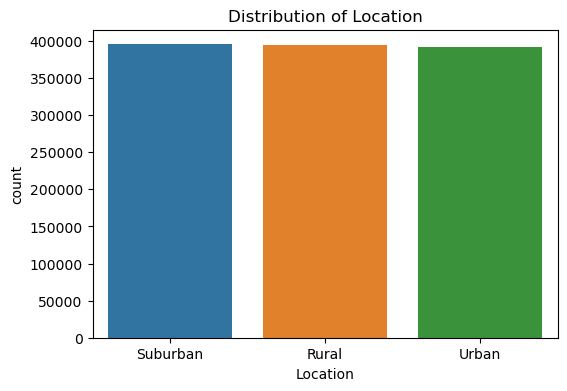

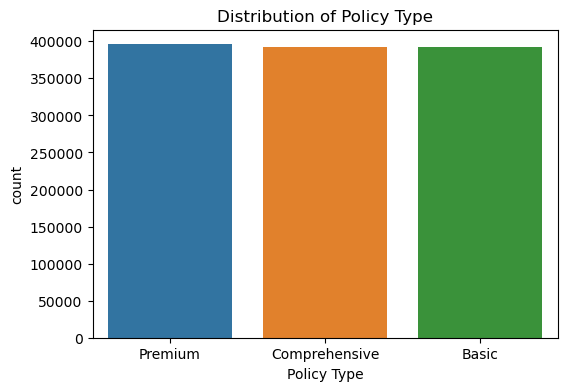

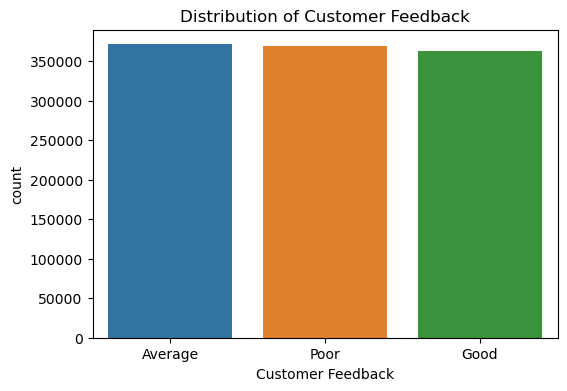

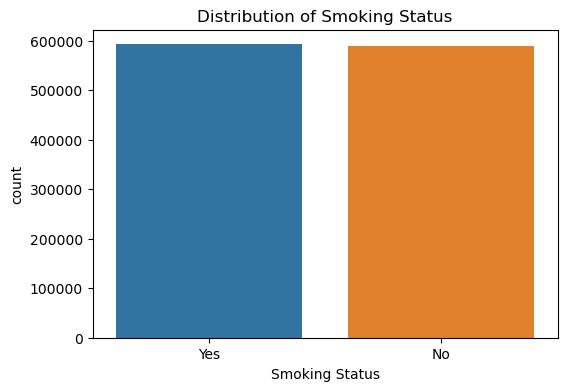

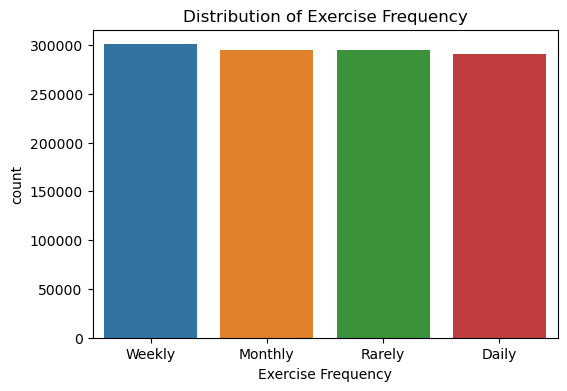

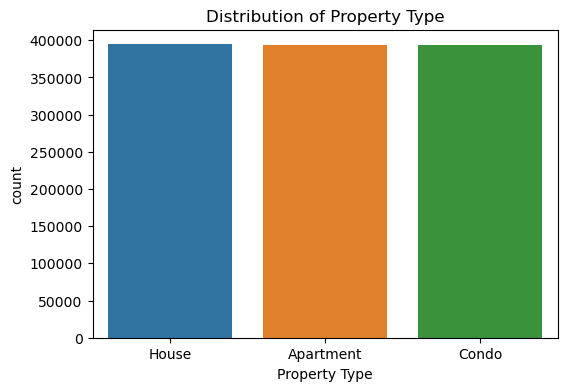

In [47]:
# distributions aare all balanced, no imbalance in all categorical features
for col in cat_col:
    plt.figure(figsize=(6,4))
    plt.title(f'Distribution of {col}')
    # train[col].value_counts().plot(kind='bar')
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)


# Feature Engineering
- Binary Encoding for categorical columns that are strictly binary in the dataset like columns: **Gender, Smoking Status**
- OneHotEncoding for categorical columns that have +3 categories like columns: **Martial Status, Education Level, Occupation, Location, Policy Type, Customer Feedback, Exercise Frequency, Property Type** 
- **Policy start date** converted to a DateTime object
- added new features such as: **Policy Days Since, policy-month, policy_quarter, etc**
- log scale right skewed numeric features: Annual Income
- log scale right skewed target: Premium Amount for training the model then return original amount by exponential(log_Premium_Amount)

In [48]:
# Create a new feature: policy_days_since. Example: how long ago the policy started (in days)
reference_date = pd.to_datetime("today")
train['policy_days_since'] = (reference_date - train['Policy Start Date']).dt.days

train['policy_year'] = train['Policy Start Date'].dt.year   # maybe older policies have different pricing structures. 
train['policy_month'] = train['Policy Start Date'].dt.month  # premiums might vary by time of year (e.g., seasonal promotions, risk cycles).
train['policy_quarter'] = train['Policy Start Date'].dt.quarter  # useful for financial business cycles
train['policy_weekday'] = train['Policy Start Date'].dt.weekday   # weekday vs weekend
train['is_weekend_start'] = (train['Policy Start Date'].dt.weekday >= 5).astype(int)
train['policy_age_years'] = train['policy_days_since'] // 365  # Interaction with target-> older policies might have renewal pricing.

# older policy + older vehicle could increase risk
train['policy_days_since_vehicleAge'] = train['policy_days_since'] * train['Vehicle Age']

# credit score * claims
train['credit_score_claims'] = train['Credit Score'] * train['Previous Claims']

# append new features into numerical features col list
new_num_features= ['policy_days_since', 'policy_year','policy_month','policy_quarter','policy_weekday','is_weekend_start',
                   'policy_days_since_vehicleAge','policy_age_years','credit_score_claims']
for c in new_num_features:
    num_col.append(c) 
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Premium Amount,policy_days_since,policy_year,policy_month,policy_quarter,policy_weekday,is_weekend_start,policy_age_years,policy_days_since_vehicleAge,credit_score_claims
0,1,32.0,Female,29892.0,Single,0.0,Bachelor's,Employed,6.607965,Suburban,...,817.0,714,2023,9,3,5,1,1,1428.0,0.0
1,2,21.0,Male,77567.0,Divorced,0.0,High School,Self-Employed,NaN,Suburban,...,1804.0,684,2023,10,4,0,0,1,0.0,NaN
2,3,61.0,Female,33226.0,Divorced,NaN,Master's,Employed,17.160862,Rural,...,513.0,1561,2021,5,2,5,1,4,24976.0,0.0
3,4,61.0,Male,34013.0,Divorced,4.0,High School,Employed,44.108344,Suburban,...,49.0,814,2023,6,2,3,0,2,4070.0,NaN
4,5,NaN,Female,NaN,Married,2.0,Bachelor's,Self-Employed,57.369206,Urban,...,1048.0,1996,2020,3,1,4,0,5,1996.0,0.0


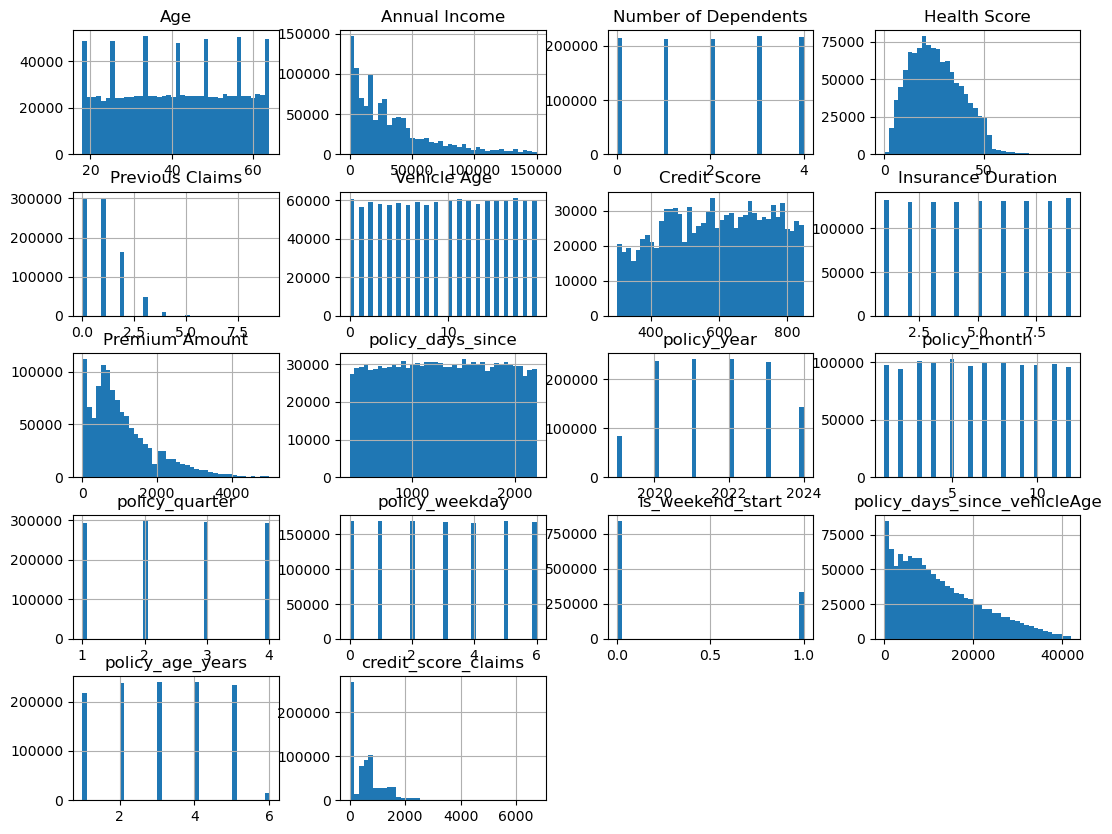

In [49]:
# visualize new features
train[num_col].hist(figsize=(13,10), bins = 40)
plt.show()

In [50]:
# checking if new the features have a better correlation with the target Premium Amount
train[num_col].corr()['Premium Amount'].sort_values(ascending=False)

Premium Amount                  1.000000
Previous Claims                 0.037695
credit_score_claims             0.034542
policy_days_since               0.008782
policy_age_years                0.007862
Health Score                    0.005802
policy_month                    0.005308
policy_days_since_vehicleAge    0.005017
policy_quarter                  0.004919
Vehicle Age                     0.000894
is_weekend_start                0.000798
policy_weekday                  0.000619
Insurance Duration              0.000377
Number of Dependents           -0.000295
Age                            -0.001925
policy_year                    -0.009506
Credit Score                   -0.015972
Annual Income                  -0.016733
Name: Premium Amount, dtype: float64

In [51]:
# ---------------strictly binary columns mapping
binary_col = ['Gender', "Smoking Status"]

# map binary columns 
train['Smoking Status'] = train['Smoking Status'].map({'Yes' : 1, 'No': 0})
train['Gender'] = train['Gender'].map({'Female' : 1, 'Male': 0})   # female ->1, male =0


In [52]:
# train[binary_col] 
# # check mapping successful by not having nan and checking unique values
for col in binary_col:
    print(col, train[col].unique())
    print(col, train[col].isna().sum())

Gender [1 0]
Gender 0
Smoking Status [1 0]
Smoking Status 0


In [53]:
train[cat_col].shape

(1181615, 10)

In [54]:
# -------------OneHotCoding for categorical columns with +3 category
from sklearn.preprocessing import OneHotEncoder

onehot_col = ['Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback',
                'Exercise Frequency', 'Property Type']
onehotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_onehot = onehotEncoder.fit_transform(train[onehot_col])

print('One Hot Encoded categorical features shape:', X_cat_onehot.shape)

One Hot Encoded categorical features shape: (1181615, 29)


In [55]:
# log transform + StandardScaler Numerical feautres
from sklearn.preprocessing import StandardScaler

# exclude target:y 
num_col = [c for c in num_col if c not in ['Premium Amount']]
print('Numerical features',num_col)

# log transform features that are Right Skewed 
train['Annual Income'] = np.log1p(train['Annual Income'])   # log1p(x) = log(1+x), safe for zeros

# Scale features
scaler = StandardScaler()
X_num = scaler.fit_transform(train[num_col])
X_num.shape

Numerical features ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'policy_days_since', 'policy_year', 'policy_month', 'policy_quarter', 'policy_weekday', 'is_weekend_start', 'policy_days_since_vehicleAge', 'policy_age_years', 'credit_score_claims']


(1181615, 17)

In [67]:
# combine numerical + categorical + binary features to one X array
X = np.hstack([X_num, X_cat_onehot, train[binary_col].values])
# X

# target variable
y= train['Premium Amount'].values

print(X.shape)
print(y.shape)

(1181615, 48)
(1181615,)


In [68]:
# Final Train dataset 

# get names for one hot encoded features
onehot_feature_names = onehotEncoder.get_feature_names_out(onehot_col)

# combine everything into one dataframe
train_new = pd.DataFrame(np.hstack([X_num, X_cat_onehot, train[binary_col].values]),
                         columns= list(num_col)+ list(onehot_feature_names) + list(binary_col))
# add target to the new train set
train_new['Premium Amount'] = y

print(train_new.shape)
train_new.head()

(1181615, 49)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,policy_days_since,policy_year,...,Exercise Frequency_Daily,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Apartment,Property Type_Condo,Property Type_House,Gender,Smoking Status,Premium Amount
0,-0.673478,0.349965,-1.416963,-1.498616,-1.01669,-1.309734,0.214653,0.765608,-1.123146,0.931267,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,817.0
1,-1.485910,1.061793,-1.416963,NaN,NaN,-1.656029,NaN,-0.391841,-1.180567,0.931267,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1804.0
2,1.468390,0.428901,NaN,-0.690768,-1.01669,1.114331,-1.259712,-0.777657,0.498039,-0.420623,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,513.0
3,1.468390,0.446376,1.406638,1.372123,NaN,-0.790292,-0.219759,1.537241,-0.931743,0.931267,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,49.0
4,NaN,NaN,-0.005162,2.387271,-1.01669,-1.482882,1.057147,-0.391841,1.330643,-1.096568,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1048.0


# Model Selection

In [69]:
# LightGBM Regressor: boosted decision tree ensemble trained on log_transformed target and returned back to normal for prediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

X = train_new.drop(columns=['Premium Amount'])      # Features
y = train_new['Premium Amount']                    # target
y_log = np.log1p(y)         # log-transform target for RMSLE alignment

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

# baseline hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',            # because we log-transform target
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,       # baseline
    'num_leaves': 255,            # baseline
    'max_depth': -1,             # no depth limit
    'feature_fraction': 0.9,     # subsample features
    'bagging_fraction': 0.8,     # subsample data
    'bagging_freq': 3,           # perform bagging every 5 iterations
    'min_child_samples':100,
    'verbose': -1,
    'random_state':42
}
# ------------Baseline LightGBM Regressor model-----------
lgbm_model = LGBMRegressor(**params, n_estimators=40000)
# ------------train the model
lgbm_model.fit(X_train,y_train,
               eval_set=[(X_val,y_val)],  # validation set 
               eval_metric='rmse',        # monitor RMSE on log-transformed target
               callbacks=[
                lgb.early_stopping(stopping_rounds=200), 
                lgb.log_evaluation(period=100)]    # prints every 100 rounds
              )

# -------------predict-- generating predictions on the validation set
y_pred_log = lgbm_model.predict(X_val)
y_pred = np.expm1(y_pred_log)   # back-transform target prediction Premium Amount not log transformed

# ---------RMSLE-------converting validation  test back to raw data since the evaluation score is already logged
rmsle = mean_squared_log_error(np.expm1(y_val),y_pred, squared=False)
print('RMSLE for LightBGM Regressor model is:', rmsle)


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.10902
[200]	valid_0's rmse: 1.10453
[300]	valid_0's rmse: 1.10363
[400]	valid_0's rmse: 1.10344
[500]	valid_0's rmse: 1.10338
[600]	valid_0's rmse: 1.10335
[700]	valid_0's rmse: 1.10332
[800]	valid_0's rmse: 1.10331
[900]	valid_0's rmse: 1.10328
[1000]	valid_0's rmse: 1.10328
[1100]	valid_0's rmse: 1.10328
[1200]	valid_0's rmse: 1.10329
[1300]	valid_0's rmse: 1.10331
Early stopping, best iteration is:
[1142]	valid_0's rmse: 1.10327
RMSLE for LightBGM Regressor model is: 1.1032740386844324


# GridSearch 
GridSearchCV in scikit-learn systematically tries all combinations of hyperparameters you give it.
For each combination, it:
Trains your model on the training fold.
Tests it on the validation fold.
Repeats this across k folds (cross-validation).
Then it picks the combination with the best average validation score.


In [70]:
# # Very time inefficient 
# from sklearn.model_selection import GridSearchCV

# # 1. Base model
# lgbm = LGBMRegressor(
#     objective='regression',
#     learning_rate=0.05,
#     n_estimators=2000,
#     random_state=42
# )

# # Phase 1 grid----- Tree Complexity------
# param_grid = {
#     'num_leaves': [31, 63, 127],
#     'max_depth': [6, 10, -1]
# }

# grid = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # since y is log-transformed
#     cv=3,
#     verbose=2
# )

# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_)
# print("Best CV RMSLE:", np.sqrt(-grid.best_score_))


In [71]:
# # -------------------------------
# # 3. Phase 2 – Learning rate + n_estimators
# # -------------------------------
# param_grid_2 = {
#     'learning_rate': [0.1, 0.05, 0.01],
#     'n_estimators': [1000, 3000, 5000]
# }

# grid2 = GridSearchCV(
#     LGBMRegressor(objective='regression', random_state=42, **best_params_1),
#     param_grid=param_grid_2,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=2
# )
# grid2.fit(X_train, y_train)

# best_params_2 = {**best_params_1, **grid2.best_params_}
# print("Phase 2 best params:", best_params_2)
# print("Phase 2 best RMSLE:", np.sqrt(-grid2.best_score_))


# # -------------------------------
# # 4. Phase 3 – Regularization
# # -------------------------------
# param_grid_3 = {
#     'min_child_samples': [20, 50, 100],
#     'lambda_l1': [0, 0.1, 1],
#     'lambda_l2': [0, 0.1, 1]
# }

# grid3 = GridSearchCV(
#     LGBMRegressor(objective='regression', random_state=42, **best_params_2),
#     param_grid=param_grid_3,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=2
# )
# grid3.fit(X_train, y_train)

# best_params_3 = {**best_params_2, **grid3.best_params_}
# print("Phase 3 best params:", best_params_3)
# print("Phase 3 best RMSLE:", np.sqrt(-grid3.best_score_))


# # -------------------------------
# # 5. Phase 4 – Subsampling
# # -------------------------------
# param_grid_4 = {
#     'feature_fraction': [0.6, 0.8, 1.0],
#     'bagging_fraction': [0.6, 0.8, 1.0],
#     'bagging_freq': [0, 5]
# }

# grid4 = GridSearchCV(
#     LGBMRegressor(objective='regression', random_state=42, **best_params_3),
#     param_grid=param_grid_4,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=2
# )
# grid4.fit(X_train, y_train)

# best_params_4 = {**best_params_3, **grid4.best_params_}
# print("Final best params:", best_params_4)
# print("Final best RMSLE:", np.sqrt(-grid4.best_score_))


# # -------------------------------
# # 6. Train final model on best params
# # -------------------------------
# final_model = LGBMRegressor(objective='regression', random_state=42, **best_params_4)
# final_model.fit(X_train, y_train)

# y_val_pred = final_model.predict(X_val)
# rmsle_final = mean_squared_log_error(np.expm1(y_val), np.expm1(y_val_pred), squared=False)
# print("Validation RMSLE with final tuned model:", rmsle_final)


In [72]:
# import optuna
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'boosting_type': 'gbdt',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 31, 255),
#         'max_depth': trial.suggest_int('max_depth', 4, 12),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 5.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0, 5.0),
#         'n_estimators': 1000,
#         'random_state': 42
#     }
    
#     model = LGBMRegressor(**params)
#     # RMSLE in log-space ≈ RMSE on log target
#     score = cross_val_score(model, X_train, y_train,
#                             scoring='neg_mean_squared_error',
#                             cv=2, n_jobs=-1)
#     return score.mean()

# # Run optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=5)   # try 50 combinations

# print("Best params:", study.best_params)
# print("Best CV RMSLE:", np.sqrt(-study.best_value))


# Predict

In [73]:
# map binary in test set exactly like train set ---- HERE WE ARE MAKING TEST dataset same as train (encoding, scaling, binary)----

# -- LAST STEP BEFORE TESTING

# Create new features in test exactly the same way as train
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'], errors='coerce')
reference_date = pd.to_datetime("today")
test['policy_days_since'] = (reference_date - test['Policy Start Date']).dt.days

test['policy_year'] = test['Policy Start Date'].dt.year   # maybe older policies have different pricing structures. 
test['policy_month'] = test['Policy Start Date'].dt.month  # premiums might vary by time of year (e.g., seasonal promotions, risk cycles).
test['policy_quarter'] = test['Policy Start Date'].dt.quarter  # useful for financial business cycles
test['policy_weekday'] = test['Policy Start Date'].dt.weekday   # weekday vs weekend
test['is_weekend_start'] = (test['Policy Start Date'].dt.weekday >= 5).astype(int)
test['policy_age_years'] = test['policy_days_since'] // 365  # Interaction with target-> older policies might have renewal pricing.
test['policy_days_since_vehicleAge'] = test['policy_days_since'] * train['Vehicle Age']
test['credit_score_claims'] = test['Credit Score'] * test['Previous Claims']
test['Annual Income'] = np.log1p(test['Annual Income'])

binary_col = ['Gender', "Smoking Status"]

# map binary columns exactly like we did in train
test['Smoking Status'] = test['Smoking Status'].map({'Yes' : 1, 'No': 0})
test['Gender'] = test['Gender'].map({'Female' : 1, 'Male': 0})   # female ->1, male =0
  
# OnhotEncod exactly like we did in train
X_num_test = scaler.transform(test[num_col])
X_cat_test = onehotEncoder.transform(test[onehot_col])

X_test = np.hstack([X_num_test, X_cat_test, test[binary_col].values])
print(X_test.shape)

# --------Predict target using our model for the test set
test_pred_log = lgbm_model.predict(X_test)
test_pred = np.expm1(test_pred_log)
print('Prediction sucessful on test set using LightGBM Regressor model')


(295404, 48)
Prediction sucessful on test set using LightGBM Regressor model


In [74]:
submission = pd.DataFrame( { 'id' : test['id'] , 'Premium Amount' : test_pred} )

file_name = 'submission.csv'
submission.to_csv(file_name, index=False)
submission

,id,Premium Amount
0,1181616,687.781059
1,1181617,706.016827
2,1181618,665.215036
3,1181619,748.388088
4,1181620,683.935934
...,...,...
295399,1477015,678.367816
295400,1477016,589.479468
295401,1477017,797.526734
295402,1477018,672.086874
